In [23]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

from utils import Missingness
from utils import knn_impute_image, mean_impute_image
from utils import load_mnist
from utils import run_dec_pipeline
from utils import plot_dec_performance

from models import Autoencoder, DEC
from utils import train_autoencoder, train_dec




In [5]:
input_dim = 784
latent_dim = 10
n_clusters = 10
learning_rate = 0.01

N_FEATURES = 784
LATENT_DIM = 10
N_CLUSTERS = 10
BATCH_SIZE = 256

K_KNN = 5
AE_EPOCHS = 25
DEC_EPOCHS = 50
missingness_percentages = np.arange(0, 100, 10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

H_W = 28

ari_scores = []
nmi_scores = []

# Loading data

In [6]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [7]:
indices = torch.arange(len(tensor_x)).to(device)
full_dataset = TensorDataset(tensor_x, indices)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

missingness = Missingness()

# Imputing mean

In [8]:
ari_scores_knn = []
nmi_scores_knn = []

In [9]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0
    print(f"\n-------- Missingness percentage {missing_rate_float} --------")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='mcar',
        missing_rate=missing_rate_float
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)

    X_imputed_image = knn_impute_image(X_missing_image, k=K_KNN)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)

    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        labels,
        indices,
        device=device,
        ae_epochs=20,
        dec_epochs=75,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores_knn.append(ari)
    nmi_scores_knn.append(nmi)

    print(f"\n RESULTS ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")


-------- Missingness percentage 0.0 --------
Autoencoder training
Epoch 10/20: average loss = 0.0128
Epoch 20/20: average loss = 0.0103
DEC training
Epoch 10/75: average loss = 0.1634
Epoch 20/75: average loss = 0.1254
Epoch 30/75: average loss = 0.1043
Epoch 40/75: average loss = 0.0902
Epoch 50/75: average loss = 0.0801
Epoch 60/75: average loss = 0.0724
Epoch 70/75: average loss = 0.0660
Epoch 75/75: average loss = 0.0634

 RESULTS (0% MCAR): ARI=0.7099 | NMI=0.7887

-------- Missingness percentage 0.1 --------
Autoencoder training
Epoch 10/20: average loss = 0.0132
Epoch 20/20: average loss = 0.0105
DEC training
Epoch 10/75: average loss = 0.1683
Epoch 20/75: average loss = 0.1285
Epoch 30/75: average loss = 0.1067
Epoch 40/75: average loss = 0.0918
Epoch 50/75: average loss = 0.0810
Epoch 60/75: average loss = 0.0729
Epoch 70/75: average loss = 0.0664
Epoch 75/75: average loss = 0.0636

 RESULTS (10% MCAR): ARI=0.7070 | NMI=0.7761

-------- Missingness percentage 0.2 --------
Aut

In [10]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI': ari_scores_knn,
    'NMI': nmi_scores_knn
})

print(results_df)

   Missingness       ARI       NMI
0            0  0.709939  0.788667
1           10  0.707002  0.776077
2           20  0.720960  0.792186
3           30  0.666066  0.748938
4           40  0.672866  0.744468
5           50  0.671814  0.741623
6           60  0.646854  0.718731
7           70  0.609949  0.676255
8           80  0.511185  0.584545
9           90  0.186222  0.257040


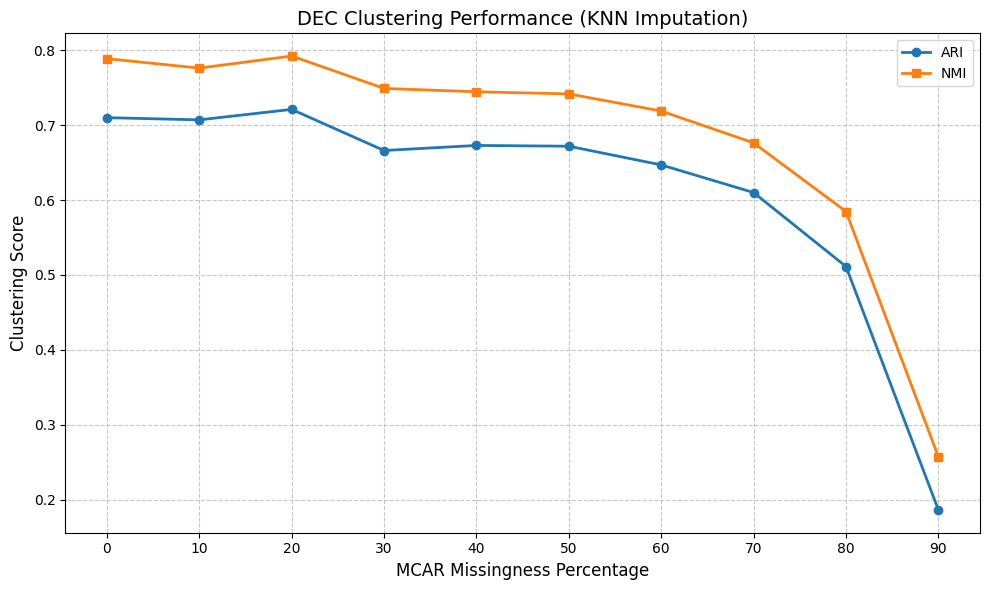

In [11]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_knn, nmi_scores_knn],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (KNN Imputation)'
)

# Mean imputation

In [ ]:
ari_scores_mean = []
nmi_scores_mean = []

In [ ]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0
    print(f"\n--- Testing Missingness {mcar_percent}% ---")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='mcar',
        missing_rate=missing_rate_float
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)
    X_imputed_image = mean_impute_image(X_missing_image)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)

    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        labels,
        indices,
        device=device,
        ae_epochs=20,
        dec_epochs=75,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores_mean.append(ari)
    nmi_scores_mean.append(nmi)

    print(f"\nPercentage ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")

In [ ]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI (Mean-DEC)': ari_scores_mean,
    'NMI (Mean-DEC)': nmi_scores_mean
})

print(results_df)

In [ ]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_mean, nmi_scores_mean],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (Mean Imputation)'
)

# Denoising Autoencoder